In [1]:
pwd

'/Users/peterhaglich/Dropbox/Work/IARPA/Mercury/peterhaglich/mercury-challenge/src/notebooks/GSR'

In [2]:
%matplotlib inline

In [3]:
import os
import json
import sys
import re

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("fivethirtyeight")

from dateutil.parser import parse
import datetime

from geopy.distance import vincenty

In [7]:
MERC_HOME = os.path.join("..", "..", "..", "..", "mercury")
MERC_HOME = os.path.abspath(MERC_HOME)
print(MERC_HOME)

MERC_DATA_PATH = os.path.join(MERC_HOME, "data")
MERC_GSR_PATH = os.path.join(MERC_DATA_PATH, "gsr")
MERC_DIS_PATH = os.path.join(MERC_GSR_PATH, "disease_gsr")
MCT_HOME = os.path.join("..", "..", "..", "..", "..")
MCT_DATA_PATH = os.path.join(MCT_HOME, "data")
MCT_GSR_PATH = os.path.join(MCT_DATA_PATH, "gsr")
MCT_DIS_PATH = os.path.join(MCT_GSR_PATH, "disease_gsr")
MCT_SRC_PATH = os.path.join(MCT_HOME, "scoring_code", "src", "main", 
                            "python", "mercury", "scoring")
MCT_DOC_PATH = os.path.join(MCT_HOME, "doc")
MCT_PLOT_PATH = os.path.join(MCT_DOC_PATH, "GSR Plots")

/Users/peterhaglich/Dropbox/Work/IARPA/Mercury/peterhaglich/mercury


In [9]:
gsr = []
dis_files = [x for x in os.listdir(MERC_DIS_PATH) if "Dup" not in x
            if x.startswith("D")
            if x.endswith("json")]
dis_files

['DISEASE_January_2017.json',
 'DISEASE_October_2016.json',
 'DISEASE_May_2016.json',
 'DISEASE_May_2017.json',
 'DISEASE_October_2017.json',
 'DISEASE_24_Jul_2018.json',
 'DISEASE_21_Aug_2018.json',
 'DISEASE_March_2017.json',
 'DISEASE_04_Sep_2018.json',
 'DISEASE_July_2016.json',
 'DISEASE_February_2017.json',
 'DISEASE_April_2018.json',
 'DISEASE_July_2017.json',
 'DISEASE_10_Jul_2018.json',
 'DISEASE_June_2018.json',
 'DISEASE_April_2017.json',
 'DISEASE_May_2015_March_2016.json',
 'DISEASE_02_Oct_2018.json',
 'DISEASE_June_2017.json',
 'DISEASE_November_2017.json',
 'DISEASE_07_Aug_2018.json',
 'DISEASE_March_2018.json',
 'DISEASE_November_2016.json',
 'DISEASE_June_2016.json',
 'DISEASE_16_Oct_2018.json',
 'DISEASE_24_Nov_2018.json',
 'DISEASE_April_2016.json',
 'DISEASE_February_2018.json',
 'DISEASE_May_2018.json',
 'DISEASE_September_2017.json',
 'DISEASE_August_2016.json',
 'DISEASE_18_Sep_2018.json',
 'DISEASE_December_2016.json',
 'DISEASE_December_2017.json',
 'DISEASE_31

In [10]:
for file_ in dis_files:
    try:
        path_ = os.path.join(MERC_DIS_PATH, file_)
        with open(path_, "r", encoding="utf8") as f:
            gsr_ = json.load(f)
            gsr += gsr_
    except json.JSONDecodeError:
        print(file_)

In [11]:
gsr_df = pd.DataFrame(gsr)
gsr_df = gsr_df[gsr_df.Country == "Saudi Arabia"]
gsr_df = gsr_df[gsr_df.Disease=="MERS"]

In [12]:
# Replace duplicated event IDs with the latest version.
gsr_df["Revision_DTG"] = gsr_df.Revision_Date.apply(parse)
for ed, group in gsr_df.groupby("Event_ID"):
    newest_index = group.Revision_DTG.argmax()
    newest_rev_date = group.Revision_Date[newest_index]
    gsr_df.set_value(group.index[0], "Revision_Date", newest_rev_date)
drop_cols = ["Revision_DTG","Approximate_Location","Latitude", "Longitude", "City",
             "State"]
for dc in drop_cols:
    gsr_df.drop(dc, axis=1, inplace=True)
gsr_df.drop_duplicates(subset="Event_ID", keep="last", inplace=True)
gsr_df["Event_ID"] = gsr_df.Event_Date.apply(lambda x: "Disease_Saudi_Arabia_MERS_{}".format(x))
gsr_df.Event_Date = gsr_df.Event_Date.apply(parse)
gsr_df.index=gsr_df.Event_Date

/anaconda3/envs/mercury_challenge/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.
/anaconda3/envs/mercury_challenge/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


FileNotFoundError: [Errno 2] No such file or directory: '../../../../../doc/GSR Plots/Weekly MERS Case Counts, Saudi Arabia.png'

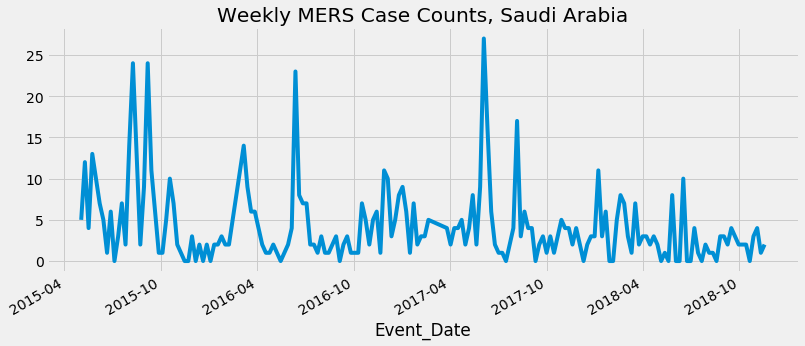

In [13]:
title_ = "Weekly MERS Case Counts, Saudi Arabia"
gsr_df.Case_Count.plot(figsize=(12,5))
plt.title(title_);
out_filename = "{}.png".format(title_)
out_path = os.path.join(MCT_PLOT_PATH, out_filename)
plt.savefig(out_path)

## Export Deduplicated Weekly GSR

In [20]:
out_filename = "Saudi_Arabia_Weekly_MERS_Counts.json"
out_path = os.path.join(MCT_DIS_PATH, out_filename)
out_json = gsr_df.to_json(force_ascii=False, orient="records", path_or_buf=out_path)